# GMM and EM
Gaussian Mixture Models and Expectation Maximization  

Here we show canned and homgrown implementations.

## Using a library call
Follow tutorial in [mastery](https://machinelearningmastery.com/expectation-maximization-em-algorithm/)

Use [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) class GaussianMixture.

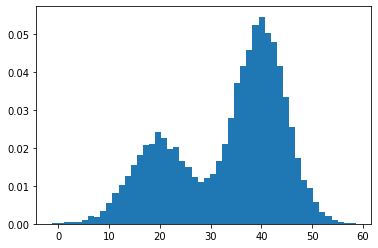

In [1]:
# Straight from the Mastery site.
# Construct a bimodal from two Gaussian processes.
from numpy import hstack
from numpy.random import normal
from matplotlib import pyplot
# normal ( mean, standard deviation, count )
def plot(X1,X2):
    X = hstack( (X1, X2) )  # horizontal stack i.e. concat
    pyplot.hist(X, bins=50, density=True)
    pyplot.show()
X1 = normal(loc=20, scale=6, size=3000) 
X2 = normal(loc=40, scale=5, size=6000)
plot(X1,X2)

In [2]:
def show_gmm(model):
    print(model)
    for i in range(model.n_components):
        print('Gaussian',i,'mean=',model.means_[i],
            'wgt=',model.weights_[i], 
            'Cov=',model.covariances_[i])

In [3]:
# Straight from the Mastery site.
# Use EM to reverse engineer the model i.e. fit a GMM to the data.
from sklearn.mixture import GaussianMixture
X = hstack( (X1, X2) ) 
X = X.reshape((len(X), 1))
# By default, covariance=‘full’: each component has its own general covariance matrix.
# Use 'spherical' (one variance per mean) since our data has only one feature.
# By default, init_params='kmeans'. Works much better than 'random'!
model = GaussianMixture(n_components=2, verbose=1, covariance_type='spherical')
model.fit(X)
show_gmm(model)

Initialization 0
Initialization converged: True
GaussianMixture(covariance_type='spherical', n_components=2, verbose=1)
Gaussian 0 mean= [39.95460303] wgt= 0.6721688584750733 Cov= 25.615962532142138
Gaussian 1 mean= [19.77901558] wgt= 0.32783114152492815 Cov= 34.035787572407855


In [4]:
yhat = model.predict(X)
print('Predicted class of a point on the left:',yhat[100])
print('Predicted class of a point on the right:',yhat[-100])

Predicted class of a point on the left: 1
Predicted class of a point on the right: 0


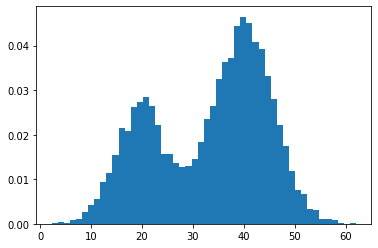

In [5]:
mean0=model.means_[0]
mean1=model.means_[1]
G0 = normal(loc=mean0, scale=6, size=3000) 
G1 = normal(loc=mean1, scale=5, size=6000)
if mean0>mean1:
    G0 = normal(loc=mean0, scale=6, size=6000) 
    G1 = normal(loc=mean1, scale=5, size=3000)
plot(G0,G1)

## Homegrown version
See [YouTube](https://youtu.be/iQoXFmbXRJA) video by Victor Lavrenko,
especially minute 3:46.

At each iteration, we have two models to explain the data.
Each model "votes" for each data point by assigning its Gaussian probability.
Critically, we use Bayes Rule to assign weights.

Bayes can use a prior if one is known.
The code can update the prior by counting cluster size,
but this can preclude convergence or converge on inferior solutions (why?).
We've seen it go on a  downhill spiral where stdev and thus prior approach 0.

In [12]:
import scipy.stats as ss
import numpy as np
def assign_probs(mean,stdev,data):
    probs=np.asarray([ss.norm.pdf(x,loc=mean,scale=stdev) for x in data])
    return probs
def bayes(prob_under_this,prior_for_this,prob_under_other):
    prior_for_other = 1-prior_for_this
    numerator = prob_under_this * prior_for_this
    denominator = numerator + prob_under_other * prior_for_other
    posterior = numerator / denominator
    return posterior
def assign_weights(probs1,probs2,prior1):
    prior2 = 1-prior1
    length = len(probs1)
    weights1=np.zeros(length)
    weights2=np.zeros(length)
    for i in range(length):    # do without for loop ?                 
        weights1[i]=bayes(probs1[i],prior1,probs2[i])  
        weights2[i]=bayes(probs2[i],prior2,probs1[i])  
    return weights1,weights2
def update_mean(weights,data):
    length = len(data)
    weighted = data*weights  # Hadamard vector multiply
    mean=sum(weighted)/sum(weights)
    return mean
def update_stdev(mean,weights,data):
    # sum of the squares of the weighted deviations from the mean
    dev = data-mean
    wdev = dev*weights
    sse = sum(wdev**2)
    stdev=float(np.sqrt(sse/sum(weights)))
    return stdev
def update_prior(probs1,probs2):
    # prior = sum(probs)/len(probs)  # doesn't work!
    length = len(probs1)
    mine = 0
    for i in range(length):
        if probs1[i]>probs2[i]:
            mine += 1
    return mine / length
def iterative_2_means(mean1,mean2,data,num_iter,update_priors):
    # initial guess is both equal to overall
    stdev1=np.std(data)
    stdev2=update_stdev(np.mean(data),np.ones(len(data)),data)  # should be same
    print('Initial means: %f +/- %d, %f +/- %d'%(mean1,stdev1,mean2,stdev2))
    prior1 = 0.5
    for i in range(num_iter):
        probs1=assign_probs(mean1,stdev1,data)
        probs2=assign_probs(mean2,stdev2,data)
        weights1,weights2 = assign_weights(probs1,probs2,prior1)
        mean1 = update_mean(weights1,data)
        mean2 = update_mean(weights2,data)
        stdev1 = update_stdev(mean1,weights1,data)
        stdev2 = update_stdev(mean2,weights2,data)
        print('Intermediate means: %f +/- %d, %f +/- %d (%f)'%(mean1,stdev1,mean2,stdev2,prior1))
        if update_priors:
            prior1=update_prior(probs1,probs2)
    print()
    print('Final means: %f +/- %d, %f +/- %d'%(mean1,stdev1,mean2,stdev2))
    return mean1,mean2,stdev1,stdev2

In [15]:
X1 = normal(loc=20, scale=6, size=3000) 
X2 = normal(loc=40, scale=5, size=6000)
guess1 = 10
guess2 = 20
X = hstack( (X1, X2) ) 
X = np.asarray(X)
mean1,mean2,stdev1,stdev2=iterative_2_means(guess1,guess2,X,20,True)

Initial means: 10.000000 +/- 10, 20.000000 +/- 10
Intermediate means: 25.548134 +/- 5, 35.482106 +/- 8 (0.500000)
Intermediate means: 20.096078 +/- 2, 34.671690 +/- 9 (0.060778)
Intermediate means: 19.335464 +/- 2, 36.581833 +/- 8 (0.348111)
Intermediate means: 18.535722 +/- 2, 36.771999 +/- 8 (0.229778)
Intermediate means: 17.906174 +/- 2, 37.129824 +/- 7 (0.235556)
Intermediate means: 17.433593 +/- 3, 37.674987 +/- 6 (0.237000)
Intermediate means: 17.444836 +/- 3, 38.291171 +/- 6 (0.245778)
Intermediate means: 18.050952 +/- 4, 38.812017 +/- 5 (0.262667)
Intermediate means: 18.560272 +/- 4, 39.206936 +/- 5 (0.283667)
Intermediate means: 18.944335 +/- 4, 39.478294 +/- 5 (0.299556)
Intermediate means: 19.219907 +/- 4, 39.654667 +/- 5 (0.310000)
Intermediate means: 19.414096 +/- 4, 39.769287 +/- 4 (0.318222)
Intermediate means: 19.546284 +/- 4, 39.842827 +/- 4 (0.322778)
Intermediate means: 19.635821 +/- 5, 39.890701 +/- 4 (0.326000)
Intermediate means: 19.697633 +/- 5, 39.922896 +/- 4 (